In [1]:
import pandas as pd
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_utils import load_data

In [2]:
main = load_data()

Aggregated data loaded in 10.179547786712646 seconds.


# Failure detection

In [3]:
from src.plots import plot_by_outcome, plot_failures_by_method

### Failure detection rate

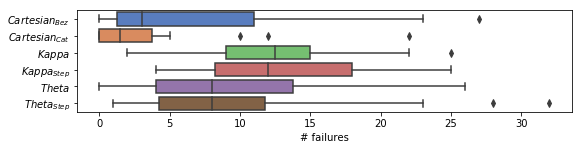

In [4]:
fig = plot_by_outcome(main, ['FAIL'], '# failures')
fig.savefig('./figures/failures.pdf')

### Failure detection rate by method

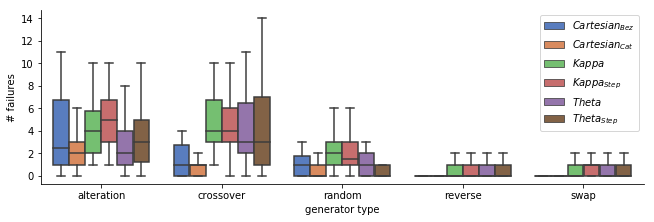

In [5]:
fig = plot_failures_by_method(main)
fig.savefig('./figures/failures_by_method.pdf')

# Analyzing number of valid tests

### Invalid tests

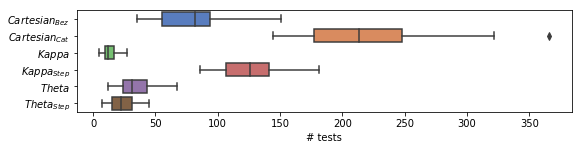

In [6]:
fig = plot_by_outcome(main, ['INVALID'], x_label='# tests')
plt.savefig('./figures/invalid.pdf')

### Valid tests

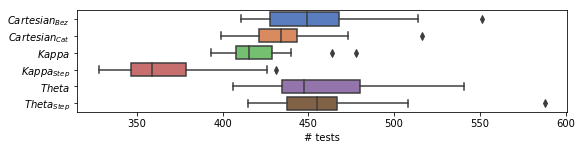

In [7]:
fig = plot_by_outcome(main, ['PASS','FAIL'], x_label='# tests')
fig.savefig('./figures/valid.pdf')

# Statistical Test for Failures

In [8]:
# The subject to test is the failures data
subject= pd.pivot_table(main[main.outcome.isin(['FAIL'])], values='test', index=['exp'], columns=['representation'], aggfunc='count', fill_value=0)
subject

representation,bezier,cartesian,kappa,kappa+step,theta,theta+step
exp,,,,,,
1,3,0,21,9,13,6
2,11,10,5,9,10,8
3,0,3,9,12,4,23
4,0,12,21,18,13,5
5,6,0,8,23,19,16
6,2,5,13,10,10,32
7,4,0,9,6,9,28
8,19,0,8,8,8,4
9,27,3,25,9,26,12


## Shapiro Test

In [9]:
from scipy.stats import shapiro
# null hypothesis: is it equal to normal distribution
# alternative: is not... 

In [10]:
ci = 0.05 # less than ci --> reject null hypothesis 

In [11]:
for rep in main.representation.unique():
    shapiro_rep = shapiro(subject[rep])
    label = '' if shapiro_rep.pvalue < ci else '(Normal)'
    print(f'{rep}: {shapiro_rep.pvalue} {label}')

bezier: 0.00011280283069936559 
cartesian: 2.2340415739563468e-07 
kappa: 0.3034754991531372 (Normal)
kappa+step: 0.1315443515777588 (Normal)
theta: 0.04509696364402771 
theta+step: 0.0006100411992520094 


Only kappa seems to be normally distributed, thus we use mannwhitney u-test

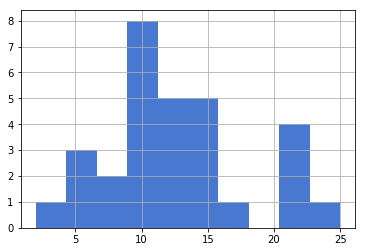

In [12]:
_ = subject['kappa'].hist()

## Mann-Whitney U-Test and A12 

In [13]:
from scipy.stats import mannwhitneyu
from src.utils.a12 import a12
from src.stats_tests import u_test_by_representations, u_test_a12_by_representation, pretty_latex

### U-Test

In [14]:
u_test = u_test_by_representations(subject, main.representation.unique())
u_test

,bezier,cartesian,kappa,kappa+step,theta,theta+step
subject,,,,,,
bezier,NaN,0.008617,4.275203e-04,1.741420e-04,0.050650,1.039423e-02
cartesian,NaN,NaN,6.514108e-09,3.431359e-09,0.000037,6.457201e-07
kappa,NaN,NaN,NaN,4.940835e-01,0.016419,9.814048e-03
kappa+step,NaN,NaN,NaN,NaN,0.017086,1.214944e-02
theta,NaN,NaN,NaN,NaN,NaN,4.264815e-01
theta+step,NaN,NaN,NaN,NaN,NaN,NaN


### U-Test with A12

In [15]:
ua12_test = u_test_a12_by_representation(subject, main.representation.unique())
ua12_test

,bezier,cartesian,kappa,kappa+step,theta,theta+step
subject,,,,,,
bezier,-,\better (0.677),\worse (0.249),\worse (0.231),\same,\worse (0.326)
cartesian,\worse (0.323),-,\worse (0.0744),\worse (0.0661),\worse (0.204),\worse (0.138)
kappa,\better (0.751),\better (0.926),-,\same,\better (0.661),\better (0.676)
kappa+step,\better (0.769),\better (0.934),\same,-,\better (0.659),\better (0.669)
theta,\same,\better (0.796),\worse (0.339),\worse (0.341),-,\same
theta+step,\better (0.674),\better (0.862),\worse (0.324),\worse (0.331),\same,-


In [16]:
pretty_latex(ua12_test)

\begin{tabular}{ccccccc}
\toprule
{} &           bezier &        cartesian &            kappa &       kappa+step &            theta &       theta+step \\
\midrule
bezier     &                - &  \better (0.677) &   \worse (0.249) &   \worse (0.231) &            \same &   \worse (0.326) \\
cartesian  &   \worse (0.323) &                - &  \worse (0.0744) &  \worse (0.0661) &   \worse (0.204) &   \worse (0.138) \\
kappa      &  \better (0.751) &  \better (0.926) &                - &            \same &  \better (0.661) &  \better (0.676) \\
kappa+step &  \better (0.769) &  \better (0.934) &            \same &                - &  \better (0.659) &  \better (0.669) \\
theta      &            \same &  \better (0.796) &   \worse (0.339) &   \worse (0.341) &                - &            \same \\
theta+step &  \better (0.674) &  \better (0.862) &   \worse (0.324) &   \worse (0.331) &            \same &                - \\
\bottomrule
\end{tabular}



## Failures by Method

In [17]:
outcomes = ['FAIL']
pt = pd.pivot_table(main[main.outcome.isin(outcomes)], values='test', index=['representation', 'exp', 'method'], aggfunc='count', fill_value=0)
# filling with zero the cases with no data and reseting the index to transform multiindex into columns
data = pt.unstack().fillna(0.0).stack().reset_index()
data

,representation,exp,method,test
0,bezier,1,alteration,0.0
1,bezier,1,crossover,1.0
2,bezier,1,random,2.0
3,bezier,1,reverse,0.0
4,bezier,1,swap,0.0
...,...,...,...,...
800,theta+step,30,alteration,2.0
801,theta+step,30,crossover,7.0
802,theta+step,30,random,0.0
803,theta+step,30,reverse,0.0


In [18]:
for method in data.method.unique():
    print('\\resizebox{\\columnwidth}{!}{')
    print('\\textbf{' +method + '} \\\\')    
    subject = pd.pivot_table(data[data.method == method], values='test', index=['exp'], columns=['representation'], aggfunc='sum', fill_value=0)
    ua12_test = u_test_a12_by_representation(subject, data.representation.unique())
    pretty_latex(ua12_test)
    print('}')

\resizebox{\columnwidth}{!}{
\textbf{alteration} \\
\begin{tabular}{ccccccc}
\toprule
{} &           bezier &        cartesian &           kappa &      kappa+step &            theta &       theta+step \\
\midrule
bezier     &                - &  \better (0.626) &  \worse (0.355) &  \worse (0.327) &            \same &            \same \\
cartesian  &   \worse (0.374) &                - &  \worse (0.183) &  \worse (0.152) &   \worse (0.367) &   \worse (0.272) \\
kappa      &  \better (0.645) &  \better (0.817) &               - &           \same &  \better (0.721) &            \same \\
kappa+step &  \better (0.673) &  \better (0.848) &           \same &               - &  \better (0.766) &  \better (0.662) \\
theta      &            \same &  \better (0.633) &  \worse (0.279) &  \worse (0.234) &                - &            \same \\
theta+step &            \same &  \better (0.728) &           \same &  \worse (0.338) &            \same &                - \\
\bottomrule
\end{tabular}

}
\r